In [37]:
from env import *
from env_tradestation import *
from data_retriever_simple import Client
import acquire
import prepare

import cbpro
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

import warnings
warnings.filterwarnings("ignore")

Basis for much of this: https://jfin-swufe.springeropen.com/track/pdf/10.1186/s40854-020-00217-x.pdf

# Personal Project - Compare the ability to predict cryptocurrency and futures prices using machine learning

## Start with acquiring crypto data
- Will acquire Bitcoin, Ethereum, and Litecoin data as these have some of the longest price histories and greatest liquidity

In [2]:
desired_products = ['BTC-USD',
 'ETH-USD',
 'LTC-USD']

In [3]:
results = acquire.get_data_from_csv()

In [4]:
prepared_results = prepare.prepare_crypto_data(results)

Max first date is 2016-08-17 00:00:00, starting all dataframes at this day
Corrected btc low data for 2017-04-15


In [5]:
btc=prepared_results['BTC_USD']

In [6]:
btc.isna().sum()

time      0
low       0
high      0
open      0
close     0
volume    0
dtype: int64

No nulls

In [7]:
btc.describe()

,low,high,open,close,volume
count,2075.000000,2075.000000,2075.000000,2075.000000,2075.000000
mean,15367.271296,16353.665287,15891.738578,15910.606708,14627.887462
std,16901.301024,17955.831798,17468.665539,17473.333789,11638.656327
min,568.120000,573.310000,570.830000,570.840000,683.798071
25%,4082.865000,4365.630000,4249.675000,4258.360000,7144.589967
50%,8215.660000,8760.430000,8522.300000,8525.070000,11718.880202
75%,17445.630000,18601.875000,17830.325000,17940.440000,18296.256136
max,66261.790000,69000.000000,67554.130000,67554.840000,130316.646844


Min btc value of 0.06 is suspicious and should be corrected

In [8]:
# Incorporated into prepare
btc.index[btc.low == 0.06]

# Gather minute data from that day to fix the low value
# minute_data = acquire.acquire_crypto_data(acquire.get_full_product_info(['BTC-USD']),datetime(2017, 4, 15, 0,0,0), datetime(2017, 4, 15, 23, 59, 0), 60)

# minute_data['BTC-USD']=minute_data['BTC-USD'].loc[(minute_data['BTC-USD'].index<'2017-04-15 23:00:00' )|(minute_data['BTC-USD'].index>'2017-04-15 23:50:00')]

# minute_data['BTC-USD'].low.min()

# btc.loc['2017-04-15','low'] = minute_data['BTC-USD'].low.min()

DatetimeIndex([], dtype='datetime64[ns]', name='time', freq=None)

In [9]:
# auth_client = cbpro.AuthenticatedClient(api_key, secret_key, passphrase)

In [10]:
# desired_products_with_info = acquire.get_full_product_info(desired_products)

In [11]:
# results = acquire.acquire_crypto_data(desired_products_with_info, datetime.now()-timedelta(days=3000), datetime.now(), minute_bars=86400)

Text(0.5, 1.0, 'Bitcoin data starts earliest\nDifferent currencies clearly at different scales')

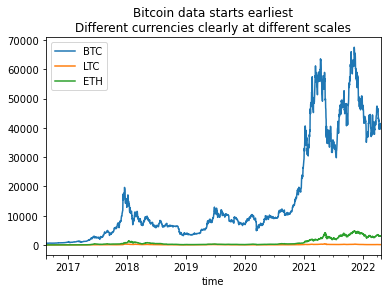

In [12]:
results['BTC_USD'].close.plot(label='BTC')
results['LTC_USD'].close.plot(label='LTC')
results['ETH_USD'].close.plot(label='ETH')
plt.legend()
plt.title('Bitcoin data starts earliest\nDifferent currencies clearly at different scales')

In [13]:
print('Min data bitcoin: ',results['BTC_USD'].index.min())
print('Min data litecoin: ',results['LTC_USD'].index.min())
print('Min data ethereum: ',results['ETH_USD'].index.min())

Min data bitcoin:  2016-08-17 00:00:00
Min data litecoin:  2016-08-17 00:00:00
Min data ethereum:  2016-08-17 00:00:00


Will truncate data so all starts at same day

### Volatility:
- relative price range: RR
- range volatility estimator of Parkinson: sigma  - lags 1-7

#### Lagged log returns, 1-7 days earlier

In [14]:
btc = prepare.add_features(btc)

## Add target and features (all added to prepare.py file)

In [15]:
# # forward 1 day log returns
# btc["log_ret_fwd"] = np.log(btc.close) - np.log(btc.close.shift(-1))
# # forward standard returns
# btc["ret_fwd"] = btc.close.shift(-1) - btc.close
# btc["pct_chg"] = btc.close.pct_change()

In [16]:
# for i in range(1,8):
#     btc[f'log_ret_lag_{i}'] = np.log(df.close) - np.log(df.close.shift(i))

## Split data

In [60]:
train_size = int(len(btc) * .5)
validate_size = int(len(btc) * .3)
test_size = int(len(btc) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = btc[: train_size]
validate = btc[train_size : validate_end_index]
test = btc[validate_end_index : ]

### Target exploration:
- primary regression target is forward log returns, which is the difference in close from tomorrow to today
- classification target is whether next close is positive
- returns used (vs absolute prices) so can compare between different time series
- if assume prices are distributed log normally then log 

<AxesSubplot:>

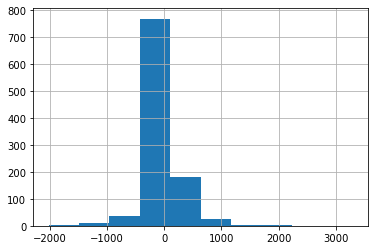

In [61]:
train.fwd_ret.hist()

Text(0.5, 1.0, 'Log returns used because assumed returns follow a log normal distribution\nLog returns are also additive to allow for compounding easily')

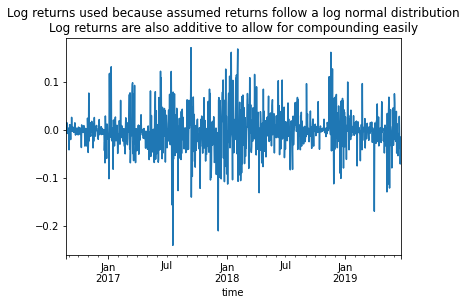

In [62]:
train.fwd_log_ret.plot()
plt.title('Log returns used because assumed returns follow a log normal distribution\nLog returns are also additive to allow for compounding easily')

Text(0.5, 1.0, 'More Normal Looking')

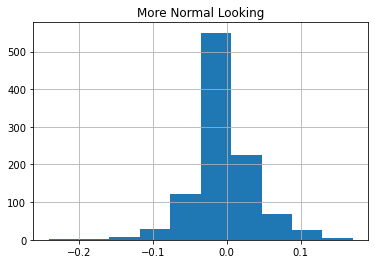

In [63]:
train.fwd_log_ret.hist()
plt.title('More Normal Looking')

<AxesSubplot:xlabel='time'>

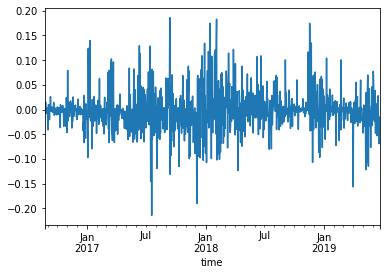

In [64]:
train.fwd_pct_chg.plot()

Text(0.5, 1.0, 'Next Close Positive - fairly balanced')

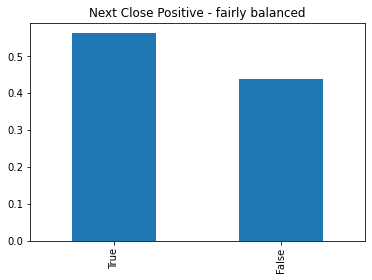

In [65]:
train.fwd_close_positive.value_counts(normalize=True).plot.bar()
plt.title('Next Close Positive - fairly balanced')

### Take a look at correlations - not very relevant given time series

In [66]:
train[[col for col in train.columns if 'day_name' not in col]].corrwith(train.fwd_log_ret).sort_values(ascending=False)

fwd_log_ret           1.000000
fwd_pct_chg           0.998780
open                  0.068015
low                   0.066747
high                  0.066128
close                 0.065933
sigma_lag_5           0.039582
sigma_lag_4           0.016418
pct_chg               0.012351
log_ret_lag_1         0.011469
log_ret_lag_4        -0.005556
sigma_lag_3          -0.012200
sigma_lag_7          -0.015279
sigma_lag_1          -0.018403
RR                   -0.018527
log_ret_lag_2        -0.020126
volume               -0.031338
log_ret_lag_3        -0.031387
log_ret_lag_7        -0.036887
log_ret_lag_5        -0.037157
sigma_lag_2          -0.045426
sigma_lag_6          -0.047553
log_ret_lag_6        -0.049871
fwd_close_positive   -0.667871
fwd_ret              -0.827821
dtype: float64

### Autocorrelation of daily close - highest correlations with lags < 50

Text(0.5, 1.0, 'No real seasonality evident')

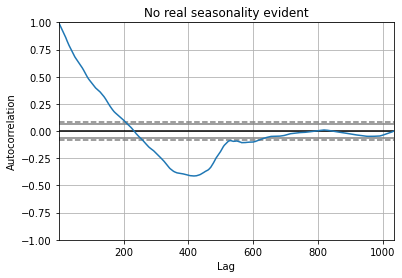

In [67]:
pd.plotting.autocorrelation_plot(train.close)
plt.title('No real seasonality evident')

# Modeling

Arima

In [68]:
series = train.fwd_log_ret

In [69]:
series

time
2016-08-24    0.005008
2016-08-25   -0.006425
2016-08-26    0.014694
2016-08-27   -0.007974
2016-08-28    0.003831
                ...   
2019-06-18   -0.021690
2019-06-19   -0.026975
2019-06-20   -0.071359
2019-06-21   -0.041211
2019-06-22   -0.015457
Name: fwd_log_ret, Length: 1033, dtype: float64

In [70]:
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            fwd_log_ret   No. Observations:                 1033
Model:                 ARIMA(5, 1, 0)   Log Likelihood                1748.733
Date:                Sun, 24 Apr 2022   AIC                          -3485.465
Time:                        11:45:03   BIC                          -3455.830
Sample:                    08-24-2016   HQIC                         -3474.219
                         - 06-22-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8694      0.022    -38.940      0.000      -0.913      -0.826
ar.L2         -0.6747      0.028    -24.369      0.000      -0.729      -0.620
ar.L3         -0.5100      0.028    -18.157      0.0

<AxesSubplot:xlabel='time'>

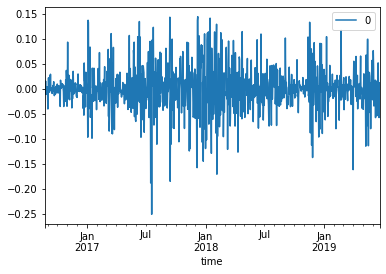

In [71]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()


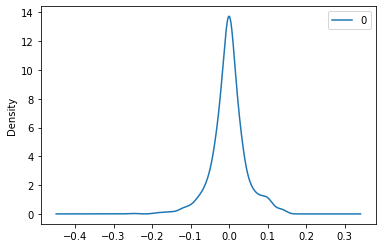

In [72]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

In [73]:
# summary stats of residuals
print(residuals.describe())

                 0
count  1033.000000
mean     -0.000120
std       0.044424
min      -0.251431
25%      -0.020097
50%       0.000341
75%       0.019180
max       0.143821


In [77]:
# split into train and test sets
X = btc.fwd_log_ret.values
size = int(len(X) * 0.66)
train_set, test_set = X[0:size], X[size:len(X)]
history = [x for x in train_set]
predictions = list()
# walk-forward validation
for t in range(len(test_set)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_set[t]
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))

Test RMSE: 0.040


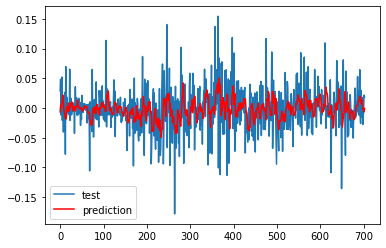

In [80]:
# evaluate forecasts
rmse = mean_squared_error(test_set, predictions,squared=False)
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test_set, label='test')
plt.plot(predictions, label='prediction',color='red')
plt.legend()
plt.show()

In [84]:
np.mean(predictions)

-0.00206048006936829

In [ ]:
y_train = train.fwd_log_ret

In [ ]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict G3_pred_mean
G3_pred_mean = y_train['G3'].mean()
y_train['G3_pred_mean'] = G3_pred_mean
y_validate['G3_pred_mean'] = G3_pred_mean

# 2. compute G3_pred_median
G3_pred_median = y_train['G3'].median()
y_train['G3_pred_median'] = G3_pred_median
y_validate['G3_pred_median'] = G3_pred_median

# 3. RMSE of G3_pred_mean
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of G3_pred_median
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))
